<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1">Description</a></span></li><li><span><a href="#Generating-TimeSeries-Data" data-toc-modified-id="Generating-TimeSeries-Data-2">Generating TimeSeries Data</a></span><ul class="toc-item"><li><span><a href="#Read-From-External-Sources" data-toc-modified-id="Read-From-External-Sources-2.1">Read From External Sources</a></span></li></ul></li><li><span><a href="#Use-Time-Series-Anaysis-functions-to-discover-anomalies" data-toc-modified-id="Use-Time-Series-Anaysis-functions-to-discover-anomalies-3">Use Time Series Anaysis functions to discover anomalies</a></span><ul class="toc-item"><li><span><a href="#Time-Series-Anomalies-using-SIEM" data-toc-modified-id="Time-Series-Anomalies-using-SIEM-3.1">Time Series Anomalies using SIEM</a></span></li><li><span><a href="#Time-Series-analysis-using-Python" data-toc-modified-id="Time-Series-analysis-using-Python-3.2">Time Series analysis using Python</a></span></li><li><span><a href="#Z-score-using-Stats-library" data-toc-modified-id="Z-score-using-Stats-library-3.3">Z-score using Stats library</a></span></li></ul></li><li><span><a href="#Visualize-Time-Series-anomalies" data-toc-modified-id="Visualize-Time-Series-anomalies-4">Visualize Time Series anomalies</a></span></li></ul></div>

 # Anomaly detection and visualization using Time Series Decomposition

## Description

This notebook demonstrates the time series analysis and anomalies visualization built using the [Bokeh library](https://bokeh.pydata.org) as well as using msticpy libraries.

Time Series analysis generally involves below steps
- Generating TimeSeries Data
- Use Time Series Analysis functions to discover anomalies
- Visualize Time Series anomalies

Read more about time series analysis in detail from reference microsoft TechCommunity blog posts

<br>***Reference Blog Posts:***
- [Looking for unknown anomalies - what is normal? Time Series analysis & its applications in Security](https://techcommunity.microsoft.com/t5/azure-sentinel/looking-for-unknown-anomalies-what-is-normal-time-series/ba-p/555052)
- [Time Series visualization of Palo Alto logs to detect data exfiltration](https://techcommunity.microsoft.com/t5/azure-sentinel/time-series-visualization-of-palo-alto-logs-to-detect-data/ba-p/666344)

Also Check out the msticpy Documentation Notebook :
[Time Series Analysis and Anomalies Visualization](https://nbviewer.jupyter.org/github/microsoft/msticpy/blob/master/docs/notebooks/TimeSeriesAnomaliesVisualization.ipynb)

In [1]:
#Imports
#msticpy imports
from msticpy.nbtools.timeseries import display_timeseries_anomolies

#pandas
import pandas as pd

#stats library to calculate z-score
from scipy import stats

#statsmodels to use STL for time series decomposition
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

#matplotlib plots for visualization
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=14)

#For widescreen view
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 

## Generating TimeSeries Data

### Read From External Sources
If you have time series data in other locations, you can read it via pandas or respective data store API where data is stored. The pandas I/O API is a set of top level reader functions accessed like pandas.read_csv() that generally return a pandas object.

Read More at Pandas Documentation:
- [I/O Tools (Text ,CSV,HDF5..)](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html)

Example of using Pandas `read_csv` to read local csv file containing TimeSeries demo dataset. 

In [2]:
timeseriesdemo = pd.read_csv(
    "https://raw.githubusercontent.com/ashwin-patil/threat-hunting-with-notebooks/master/rawdata/HostLogons-demo.csv", parse_dates=["Date"], infer_datetime_format=True
)

#show sample records
timeseriesdemo.head()

,Date,EventId,AccountNtdomain,ComputerName,logontype,TotalLogons
0,2018-01-03,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,10,2
1,2018-01-03,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,3,106
2,2018-01-03,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,4,68
3,2018-01-04,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,3,53
4,2018-01-04,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,4,89


In [3]:
# Aggregate and sum of Total Logons
timeseriesdemo_agg = timeseriesdemo.groupby(['Date','ComputerName'])['TotalLogons'].sum().reset_index()
timeseriesdemo_agg = timeseriesdemo_agg[['Date','TotalLogons']].set_index('Date')
timeseriesdemo_agg

,TotalLogons
Date,
2018-01-03,176
2018-01-04,142
2018-01-05,85
2018-01-06,147
2018-01-07,142
...,...
2018-04-26,180
2018-04-27,98
2018-04-28,106


## Use Time Series Anaysis functions to discover anomalies
By analyzing time series data over an extended period, we can identify time-based patterns (e.g. seasonality, trend etc.) in the data and extract meaningful statistics which can help in flagging outliers.  A particular example in a security context is user logon patterns over a period of time exhibiting different behavior after hours and on weekends: computing deviations from these changing patterns is rather difficult in traditional atomic detections with static thresholds. KQL built-in functions can automatically identify such seasonality and trend from the input data and take it into consideration when flagging anomalies.

### Time Series Anomalies using SIEM
***Azure Sentinel KQL Reference Documentation:***
- [series_decompose](https://docs.microsoft.com/en-us/azure/kusto/query/series-decomposefunction)
- [series_decompose_anomalies](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/query/series-decompose-anomaliesfunction)

***Splunk Time Series/ML References:***
- [Detecting Anomalies](https://docs.splunk.com/Documentation/Splunk/8.0.3/Search/Detectinganomalies)
- [About Time Series Forecasting](https://docs.splunk.com/Documentation/Splunk/8.0.3/Search/Aboutpredictiveanalytics)
- [Splunk MLApp](https://docs.splunk.com/Documentation/MLApp/5.1.0/User/SmartOutlierAssistant)

***ElasticSearch Time Series/ML References:***
- [Anomaly Detection](https://www.elastic.co/guide/en/kibana/current/xpack-ml-anomalies.html)

### Time Series analysis using Python
***Python Statsmodels TSA Library***
- [Seasonal-Trend decomposition using LOESS (STL)](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)

STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components

### Z-score using Stats library
Z-score (also called a standard score) gives you measurement for the distance from the mean value.

- [z-score](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html)
Compute the z score of each value in the sample, relative to the sample mean and standard deviation.

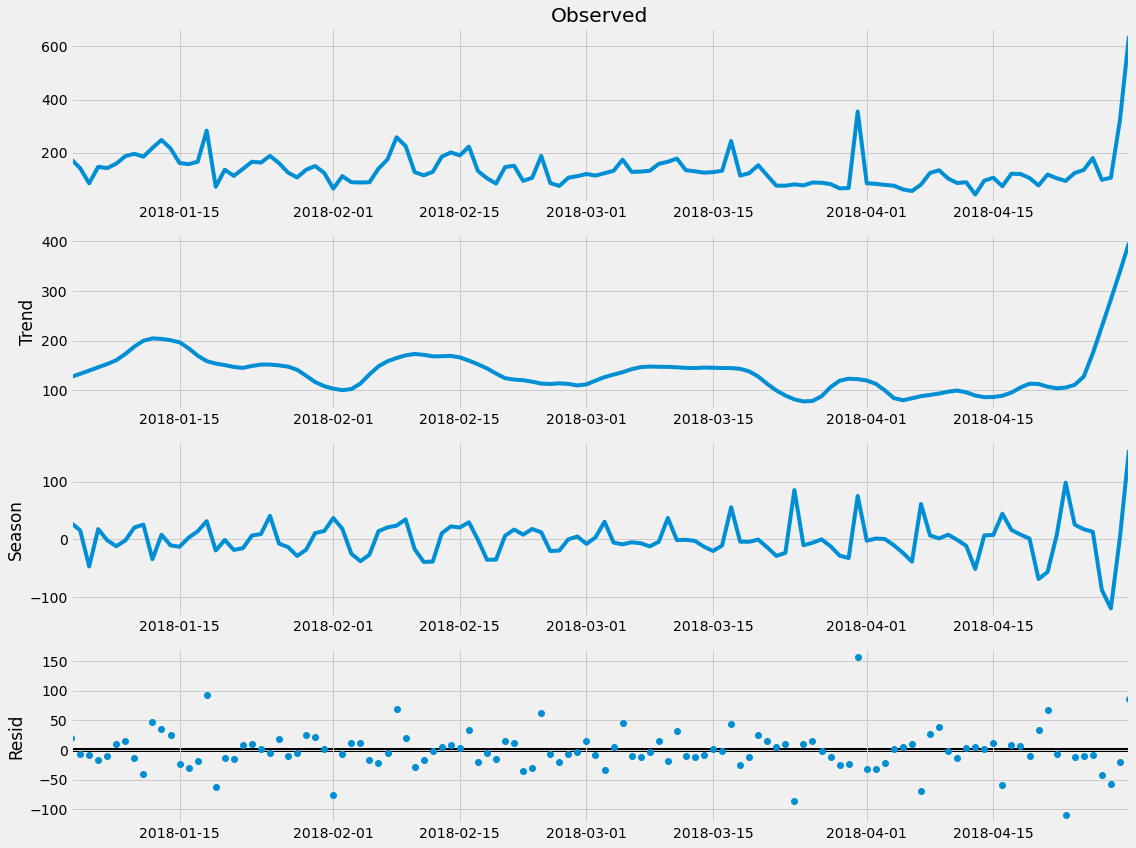

In [4]:
# STL method does Season-Trend decomposition using LOESS
stl = STL(timeseriesdemo_agg)
#Fitting the data - Estimate season, trend and residuals components.
res = stl.fit()
# Plotting the result from fit method
fig = res.plot()

In [5]:
def tsa_using_stl(data,score_threshold):
    
    output = data.copy()
    
    # Create dataframe columns from decomposition results
    output['residual']= res.resid
    output['trend']= res.trend
    output['seasonal'] = res.seasonal
    output['weights'] = res.weights
    
    #Baseline is generally seasonal + trend 
    output['baseline'] = output['seasonal']+output['trend']
    
    # Type cast and replace na values with 0
    output = output.fillna(0).astype('int64')
    
    # Calculate zscore based on residual column - this column does not contain seasonal/trend components
    output['score'] = stats.zscore(output['residual'])
    
    # create positive and negative columns based on threshold(3) and seasonal components
    output.loc[(output['score'] > score_threshold) & (output['seasonal'] > 0),'anomalies'] = 1
    output.loc[(output['score'] > score_threshold) & (output['seasonal'] < 0),'anomalies'] = -1
    output.loc[(output['score'] < score_threshold),'anomalies'] = 0
    
    #Datatype casting
    output['anomalies']=output['anomalies'].astype('int64')
    output = output.reset_index()
    
    return output

In [6]:
STL_df = tsa_using_stl(timeseriesdemo_agg, 2.5)

#Display sample results
STL_df.head()

,Date,TotalLogons,residual,trend,seasonal,weights,baseline,score,anomalies
0,2018-01-03,176,20,126,28,1,155,0.623482,0
1,2018-01-04,142,-6,133,15,1,148,-0.156633,0
2,2018-01-05,85,-7,139,-47,1,92,-0.186638,0
3,2018-01-06,147,-17,146,17,1,164,-0.486682,0
4,2018-01-07,142,-9,152,-1,1,151,-0.246647,0


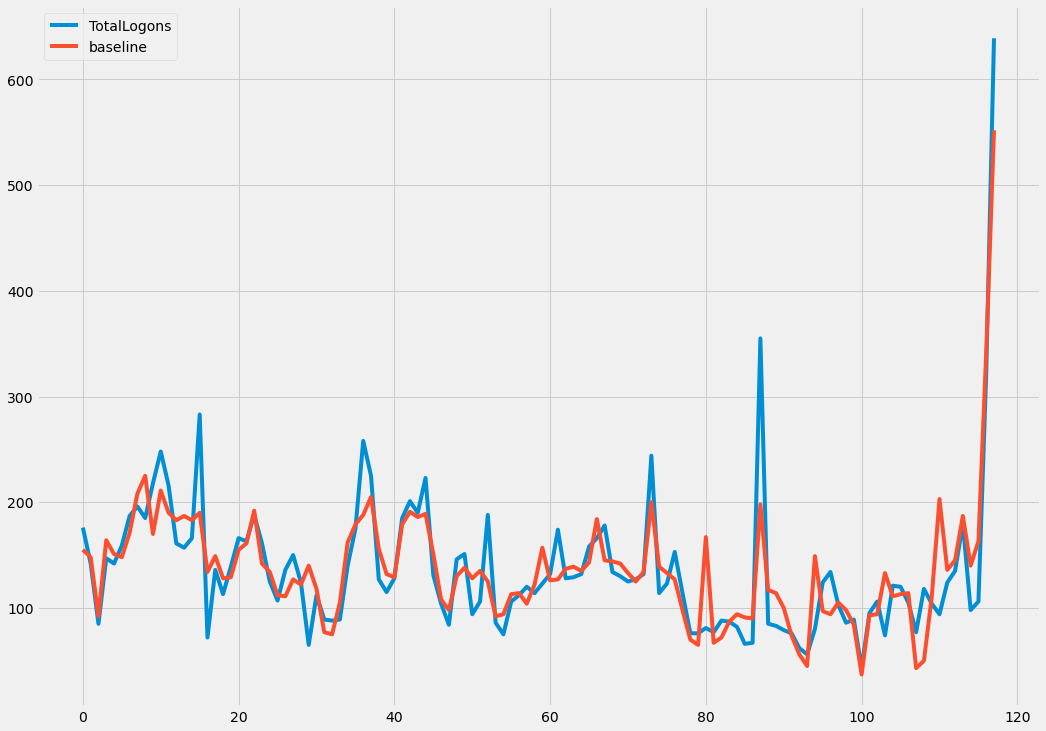

In [7]:
# Now we have baseline calculated , lets plot a Overlapping time chart to compare observed/actual values vs baseline
STL_df[['TotalLogons','baseline']].plot()

In [8]:
# Filter the dataframe and displaying only Flagged anomalies
STL_df[STL_df['anomalies']==1]

,Date,TotalLogons,residual,trend,seasonal,weights,baseline,score,anomalies
15,2018-01-18,283,92,158,31,1,190,2.783802,1
87,2018-03-31,355,156,122,75,1,198,4.704087,1
117,2018-04-30,639,86,397,155,1,552,2.603776,1


## Visualize Time Series anomalies

In [9]:
timeseries_anomalies_plot = display_timeseries_anomolies(data=STL_df, y="TotalLogons",time_column='Date')

Loading BokehJS ...